<a href="https://colab.research.google.com/github/kitigai/LearnDL/blob/master/GAN/anime_DCGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q kaggle
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kazumamorita","key":"bf28470b91244908fb4819bede7c7a4a"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
vzrenggamani/hanacaraka                                     Aksara Jawa / Hanacaraka                           9MB  2020-07-10 15:09:31             59  
vishnuvarthanrao/windows-store                              Windows Store                                     93KB  2020-07-07 12:29:07            975  
andrewmvd/data-analyst-jobs                                 Data Analyst Jobs                                  2MB  2020-07-14 08:37:57           1705  
mrgeislinger/bart-ridership                                 BART Ridership                                   325MB  2020-07-09 22:28:07            179  
rohanrao/chai-time-data-science                             Chai Time Data Science

In [8]:
#kaggle competitions download -c 'name-of-competition'
! kaggle datasets download -d soumikrakshit/anime-faces

 97% 429M/441M [00:06<00:00, 94.2MB/s]
100% 441M/441M [00:06<00:00, 73.6MB/s]


In [9]:
! unzip anime-faces.zip -d anime-faces

Streaming output truncated to the last 5000 lines.
  inflating: anime-faces/data/data/55.png  
  inflating: anime-faces/data/data/550.png  
  inflating: anime-faces/data/data/5500.png  
  inflating: anime-faces/data/data/5501.png  
  inflating: anime-faces/data/data/5502.png  
  inflating: anime-faces/data/data/5503.png  
  inflating: anime-faces/data/data/5504.png  
  inflating: anime-faces/data/data/5505.png  
  inflating: anime-faces/data/data/5506.png  
  inflating: anime-faces/data/data/5507.png  
  inflating: anime-faces/data/data/5508.png  
  inflating: anime-faces/data/data/5509.png  
  inflating: anime-faces/data/data/551.png  
  inflating: anime-faces/data/data/5510.png  
  inflating: anime-faces/data/data/5511.png  
  inflating: anime-faces/data/data/5512.png  
  inflating: anime-faces/data/data/5513.png  
  inflating: anime-faces/data/data/5514.png  
  inflating: anime-faces/data/data/5515.png  
  inflating: anime-faces/data/data/5516.png  
  inflating: anime-faces/data/dat

In [10]:
import imageio
import glob
import numpy as np
faces = []
for im_path in glob.glob("anime-faces/data/data/*.png"):
  im = imageio.imread(im_path)
  faces.append(im)
faces = np.array(faces)

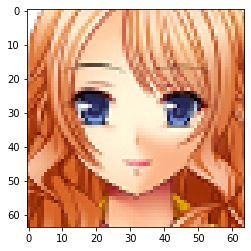

In [11]:
from matplotlib import pyplot as plt

plt.imshow(faces[1])

In [12]:

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Activation, Input, LeakyReLU, Reshape, MaxPooling2D, Conv2D, Conv2DTranspose, ReLU, Dropout
from keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers.normalization import BatchNormalization
#from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
# import datasets
from keras.datasets import fashion_mnist
# for progress bar
from IPython.display import HTML, display
import time


Using TensorFlow backend.


In [13]:
class GAN():
  def __init__(self):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    optimizer = Adam(1e-4)

    self.discriminator = self.define_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    self.generator = self.define_generator()
    self.generator.compile(loss='binary_crossentropy', optimizer = optimizer)

    z = Input(shape=(100,))
    img = self.generator(z)

    self.discriminator.trainable = False

    valid = self.discriminator(img)

    self.combined = Model(z, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def define_generator(self):
    noise_shape = (100, )
    model = Sequential()

    model.add(Dense(4*4*512, input_shape=noise_shape, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((4,4,512)))
    assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size
    model.add(Conv2DTranspose(512, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 32, 32, 128) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding="same", use_bias=False, kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 64, 64, 64) # Note: None is the batch size
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(3, kernel_size=(4,4), strides=(1,1), padding="same", use_bias=False, activation='tanh', kernel_initializer= TruncatedNormal(stddev=0.02)))
    assert model.output_shape == (None, 64, 64, 3) # Note: None is the batch size

    noise =  Input(shape=noise_shape)
    img = model(noise)
    
    return(Model(noise, img))

  def define_discriminator(self):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=self.img_shape)
    validity = model(img)

    return(Model(img, validity))

  def train(self, epochs, batch_size=128, save_interval=50):

    # reshape into 0 - 1
    X_train = (faces - 127.5) / 127.5
    # add channel dim
    #X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)
    # prepareing progress bar
    out = display(self.progress(0, 100), display_id=True)
    for epoch in range(epochs):

      #train discriminator
      #self.generator.trainable = False
      #self.discriminator.trainable = True
      idx = np.random.randint(0, X_train.shape[0], half_batch)
      imgs = X_train[idx]

      noise = np.random.normal(0, 1, (half_batch, 100))
      gen_imgs = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #train generator
      #self.generator.trainable = True
      #self.discriminator.trainable = False
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_y = np.array([1] * batch_size)
      g_loss = self.combined.train_on_batch(noise, valid_y)
      #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      out.update(self.progress(epoch % save_interval, save_interval))
      # If at save interval => save generated image samples
      if epoch % save_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        self.save_imgs(epoch)
  
  def save_imgs(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = self.generator.predict(noise)
    print(gen_imgs.shape)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    #plt.imshow(gen_imgs[0,:,:,0])
    plt.imshow(gen_imgs[0])
    plt.show()
        
    fig, axs = plt.subplots(r, c)
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            #axs[i,j].imshow(gen_imgs[cnt], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    #fig.savefig("gan/images/mnist_%d.png" % epoch)
    plt.show()
    plt.close()

  def progress(self, value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


In [16]:
gan = GAN()

In [19]:
gan.train(epochs=60000, batch_size=32, save_interval=6000)
gan.generator.save("./drive/My Drive/generator.model")
gan.combined.save("./drive/My Drive/combined.model")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


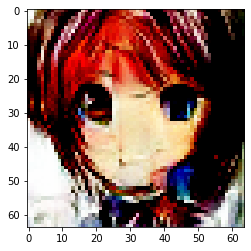

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


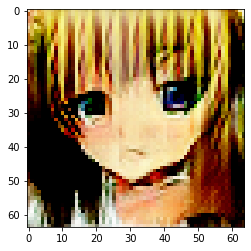

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


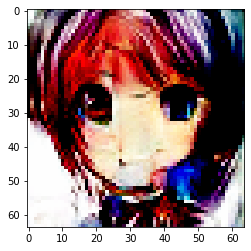

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


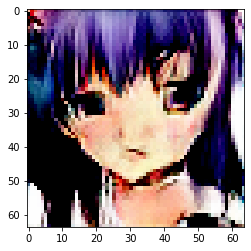

In [68]:
noise = np.random.normal(0, 1, (4, 100))
imgs = gan.generator.predict(noise)
for im in imgs:
  plt.imshow(im)
  plt.show()

In [33]:
noise.shape

(4, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 100)


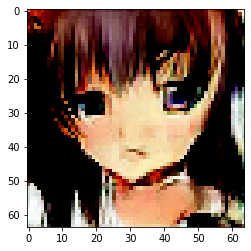

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


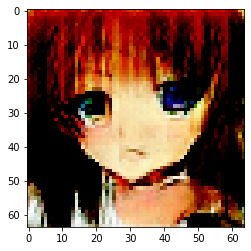

In [65]:
zero1 = np.ones((100,))
zero = np.ones((100,))
zero[0:20] = 0.5
zero[70:99] = 0.1
noise1 = np.array([zero1,zero])
noise1_1 = noise1
print(noise1.shape)
img1 = gan.generator.predict(noise1)
plt.imshow(img1[0])
plt.show()
plt.imshow(img1[1])
plt.show()